In [56]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from skimage.io import imread
from glob import glob
import warnings
import cv2
import time
from skimage.color import rgb2gray

warnings.filterwarnings('ignore')
%matplotlib inline

import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

from sklearn.model_selection import cross_val_score

from sklearn.neighbors import KNeighborsClassifier

from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.decomposition import PCA

from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression

from sklearn.svm import SVC

In [2]:
from pathlib import Path

if os.name == 'nt':
    file_path = 'C:\\JL\\Master\\DSE_I2100_Applied Machine Learning and Data Mining\\Final_Project\\lgg-mri-segmentation'
else:
    file_path = os.path.join(os.path.expanduser("~"), "Downloads/")

## Comment below if using outside of collab
#file_path='/'

In [3]:
file_path

'/Users/juanguerrero/Downloads/'

In [4]:
# Set parameters
Size = (256, 256)
# mask_files = glob(file_path + os.path.join('kaggle_3m','*','*_mask*'))
mask_files = glob(file_path + os.path.join('kaggle_3m','*','*_mask*'))
train_files = [file.replace('_mask', '') for file in mask_files]

In [5]:
def label(mask):
    value = np.max(imread(mask))
    return '1' if value > 0 else '0'
df = pd.DataFrame({"image": train_files,
                   "mask": mask_files,
                  "label":[label(x) for x in mask_files]})

In [6]:
df.shape

(5302, 3)

In [7]:
df.head()

,image,mask,label
0,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
1,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
2,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
3,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0
4,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,/Users/juanguerrero/Downloads/kaggle_3m/TCGA_C...,0


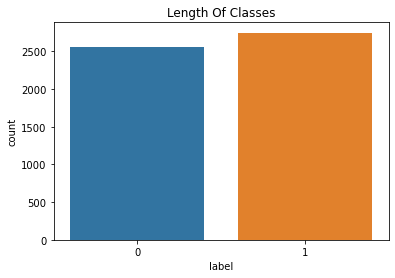

In [8]:
sns.countplot(data=df,x=df['label'])
plt.title('Length Of Classes')
plt.savefig('length_of_classes.png')
plt.show()

In [9]:
from skimage.color import rgb2gray

image_dataset = []

for path in df["image"]:
  image_dataset.append(rgb2gray(cv2.imread(path)).reshape(-1))

image_dataset_np = np.array(image_dataset)


image_df = pd.DataFrame(image_dataset_np)

In [10]:
image_df.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
1,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
2,0.003639,0.003639,0.003639,0.003639,0.003639,0.003922,0.003922,0.003922,0.003922,0.003922,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
3,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833
4,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,0.003639,...,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833,0.000833


In [11]:
from sklearn.model_selection import train_test_split

X = image_df
y = df.label

print(X.shape)
print(y.shape)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


(5302, 65536)
(5302,)


### Run a Random Forest classifier without any image pre-processing

#### Initialize and train

In [12]:
start = time.time()
clf = RandomForestClassifier(n_estimators=300 ,random_state=0)
clf.fit(X_train, y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  148.00955605506897 seconds


#### Predict

In [13]:
start = time.time()
ytest_pred = clf.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  1.762882947921753 seconds


### Image Compression using PCA

We will use PCA to choose the right number of dimensions (i.e the right number of principal components)

In [14]:
pca = PCA()

In [15]:
pca.fit(image_df)

PCA()

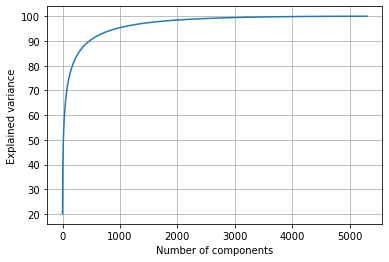

In [16]:
plt.grid()
plt.plot(np.cumsum(pca.explained_variance_ratio_*100))
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.savefig('All_PCA.png')
plt.show()

#### PCA with 10 components

Lets try out the first 10 components to compress the image. As you may notice, the first 10 components might not capture all of the variability from the original data thus genreating a blurry image.

In [17]:
pca_10 = PCA(n_components=10)
pca_reduced_10 = pca_10.fit_transform(image_df)
pca_recovered_10 = pca_10.inverse_transform(pca_reduced_10)

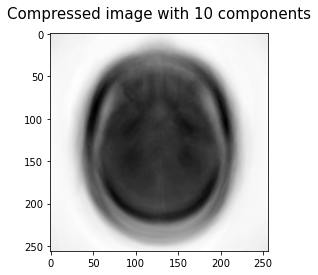

In [18]:
img_pca_10 = pca_recovered_10[1,:].reshape([256,256])
plt.imshow(img_pca_10, cmap='gray_r')
plt.title('Compressed image with 10 components', fontsize=15, pad=15)
plt.savefig('pca_10_comp.png')
plt.show()

#### PCA with 1000 components 

Next lets try 1000 components and view the image to see if the clarity increased

In [19]:
pca_1000 = PCA(n_components=1000)
pca_reduced_1000 = pca_1000.fit_transform(image_df)
pca_recovered_1000 = pca_1000.inverse_transform(pca_reduced_1000)

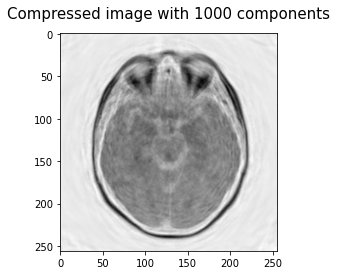

In [20]:
img_pca_1000 = pca_recovered_1000[1,:].reshape([256,256])
plt.imshow(img_pca_1000, cmap='gray_r')
plt.title('Compressed image with 1000 components', fontsize=15, pad=15)
plt.savefig('pca_1000_comp.png')
plt.show()

#### PCA with 90% of the components

It seems that we can get away with using the number of components that yield 90% of the overall variability. This number is exactly 329 components

In [21]:
pca_90_percent = PCA(n_components=.9)
pca_reduced_90_percent = pca_90_percent.fit_transform(image_df)
pca_recovered_90_percent = pca_90_percent.inverse_transform(pca_reduced_90_percent)

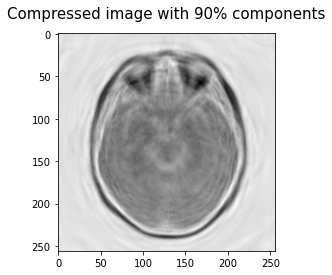

In [22]:
pca_90_percent_img = pca_recovered_90_percent[1,:].reshape([256,256])
plt.imshow(pca_90_percent_img, cmap='gray_r')
plt.title('Compressed image with 90% components', fontsize=15, pad=15)
plt.savefig('pca_90_per_comp.png')
plt.show()

In [23]:
pca_reduced_90_percent.shape

(5302, 470)

In [24]:
## Re-assign the X value and re-run a train-test split

X = pca_reduced_90_percent

## Check the shape
print(X.shape)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

(5302, 470)


#### Re run the Random Forest Classifier and read its performance

##### Initialize and train

In [25]:
start = time.time()
RFC = RandomForestClassifier(n_estimators=300 ,random_state=0)
RFC.fit(X_train, y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  11.987895965576172 seconds


##### Predict

In [26]:
start = time.time()
ytest_pred = RFC.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  0.09901309013366699 seconds


In [27]:
print ("Accuracy RF= ", metrics.accuracy_score(y_test,ytest_pred))

Accuracy RF=  0.8725714285714286


In [28]:
print('              =======Classification Report RF========')
print('')
print (metrics.classification_report(y_test,ytest_pred))

              =======Classification Report RF========

              precision    recall  f1-score   support

           0       0.92      0.80      0.86       844
           1       0.84      0.94      0.88       906

    accuracy                           0.87      1750
   macro avg       0.88      0.87      0.87      1750
weighted avg       0.88      0.87      0.87      1750



In [29]:
cm = confusion_matrix(y_test,ytest_pred)

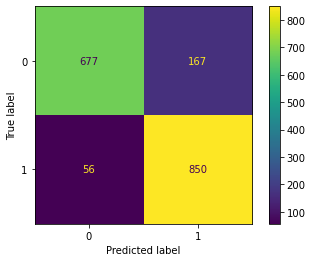

In [30]:
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.savefig('RFC_Conf_Matrix.png')

### Lets now run a support vector machine classifier

#### Initialize and train

In [31]:
start = time.time()
SVM = SVC(kernel='rbf', probability=True)
SVM.fit(X_train,y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  12.627113819122314 seconds


#### Predict

In [32]:
start = time.time()
ytest_pred = SVM.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  1.1989569664001465 seconds


In [33]:
print ("Accuracy SVM= ", metrics.accuracy_score(y_test,ytest_pred))

Accuracy SVM=  0.9045714285714286


In [34]:
print('              =======Classification Report SVM========')
print('')
print (metrics.classification_report(y_test,ytest_pred))

              =======Classification Report SVM========

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       844
           1       0.89      0.93      0.91       906

    accuracy                           0.90      1750
   macro avg       0.91      0.90      0.90      1750
weighted avg       0.91      0.90      0.90      1750



In [35]:
cm = confusion_matrix(y_test,ytest_pred)

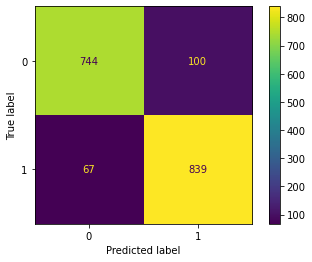

In [36]:
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.savefig('SVM_Conf_Matrix.png')

### Now Lets run a KNN Classifier

#### Initialize and Train

In [73]:
start = time.time()
neigh = KNeighborsClassifier()
neigh.fit(X_train,y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  0.005682229995727539 seconds


#### Predict

In [74]:
start = time.time()
ytest_pred = neigh.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  0.17095279693603516 seconds


In [75]:
print ("Accuracy KNN= ", metrics.accuracy_score(y_test,ytest_pred))

Accuracy KNN=  0.8862857142857142


In [76]:
print('              =======Classification Report KNN========')
print('')
print (metrics.classification_report(y_test,ytest_pred))

              =======Classification Report KNN========

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       844
           1       0.90      0.88      0.89       906

    accuracy                           0.89      1750
   macro avg       0.89      0.89      0.89      1750
weighted avg       0.89      0.89      0.89      1750



In [87]:
cm = confusion_matrix(y_test,ytest_pred)

In [ ]:
cm_display = ConfusionMatrixDisplay(cm).plot()
plt.savefig('KNN_Conf_Matrix.png')

### Other Models

In [37]:
### Naive Bayes
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
print('              =======Classification Report Naive Bayes========')
print('')
print (metrics.classification_report(y_test,y_pred))

              =======Classification Report Naive Bayes========

              precision    recall  f1-score   support

           0       0.55      0.67      0.60       844
           1       0.61      0.48      0.54       906

    accuracy                           0.57      1750
   macro avg       0.58      0.57      0.57      1750
weighted avg       0.58      0.57      0.57      1750



In [38]:
### Linear Logistic Regression
lr = LogisticRegression(random_state=0).fit(X, y)
y_pred = lr.fit(X_train, y_train).predict(X_test)
print('              =======Classification Report Linear Logistic Regression========')
print('')
print (metrics.classification_report(y_test,y_pred))

              =======Classification Report Linear Logistic Regression========

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       844
           1       0.85      0.83      0.84       906

    accuracy                           0.83      1750
   macro avg       0.83      0.83      0.83      1750
weighted avg       0.83      0.83      0.83      1750



In [39]:
### SVM Linear
SVM_lin = SVC(kernel='linear')
y_pred = SVM_lin.fit(X_train, y_train).predict(X_test)
print('              =======Classification Report SVM Linear========')
print('')
print (metrics.classification_report(y_test,y_pred))

              =======Classification Report SVM Linear========

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       844
           1       0.85      0.83      0.84       906

    accuracy                           0.83      1750
   macro avg       0.83      0.83      0.83      1750
weighted avg       0.83      0.83      0.83      1750



In [77]:
clf_labels = ['Support Vector Machine', 'Random Forest Classifier', 'KNN']
all_clf = [SVM, RFC, neigh]

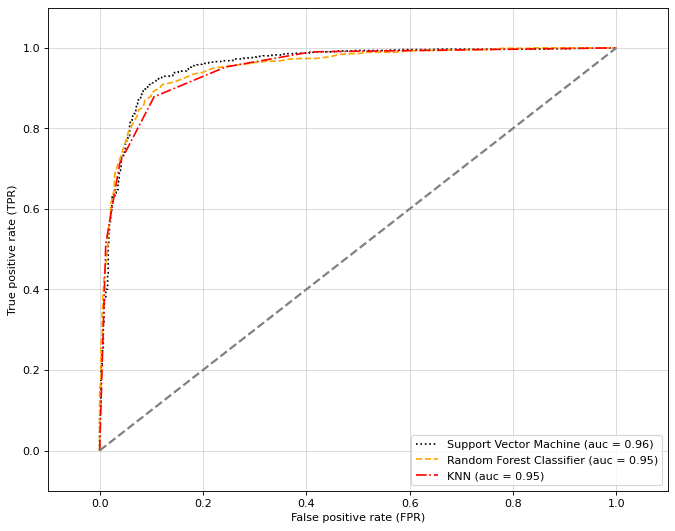

In [79]:
colors = ['black', 'orange', 'red']
linestyles = [':','--','-.']

figure(figsize=(10, 8), dpi=80)
for clf, label, clr, ls in zip (all_clf, clf_labels, colors, linestyles):
    
#     y_pred = clf.predict(X_test).ravel().astype(int)
#     fpr, tpr, thresholds = roc_curve(np.array(y_test.values).astype(int), y_pred)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test.values.astype(int), y_score=y_pred)
    
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.savefig('ROC_RFC_SVM.png')
plt.show()

### 10-Fold Cross Validation

We perform this to check the models to see how they behave with subsets of the training data

In [80]:
print('10-fold cross validation \n')
for clf_, label in zip([SVM, RFC,neigh], clf_labels):
    scores = cross_val_score(estimator=clf_, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f +/- %0.2f [%s]" 
          % (scores.mean(), scores.std(), label))

10-fold cross validation 

ROC AUC: 0.94 +/- 0.01 [Support Vector Machine]
ROC AUC: 0.94 +/- 0.01 [Random Forest Classifier]
ROC AUC: 0.94 +/- 0.01 [KNN]


### Majority Voting Classifier

In [88]:
start = time.time()
VC = VotingClassifier(estimators=[('SVM', SVM), ('RF', RFC),('KNN', neigh)], voting='hard')
VC.fit(X_train,y_train)
end = time.time()
print('Total time to initialize and train the classifier: ', end-start, 'seconds')

Total time to initialize and train the classifier:  23.603979110717773 seconds


In [89]:
start = time.time()
ytest_pred = VC.predict(X_test)
end = time.time()
print('Total time to make a prediction on the test dataset: ', end-start, 'seconds')

Total time to make a prediction on the test dataset:  1.4239096641540527 seconds


In [90]:
print ("Accuracy VC= ", metrics.accuracy_score(y_test,ytest_pred))

Accuracy VC=  0.9068571428571428


In [91]:
print('              =======Classification Report VC========')
print('')
print (metrics.classification_report(y_test,ytest_pred))

              =======Classification Report VC========

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       844
           1       0.89      0.93      0.91       906

    accuracy                           0.91      1750
   macro avg       0.91      0.91      0.91      1750
weighted avg       0.91      0.91      0.91      1750



In [107]:
def plot_confusion_matraix(model, X_test, y_test, threshold=0.5):
    y_pred = model.predict(X_test)
    y_pred = np.where(y_pred >= threshold, 1, 0)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    cm = pd.DataFrame(cm, range(2), range(2))
    cm.iloc[:, 0] = round(cm.iloc[:, 0] / cm.iloc[:, 0].sum(), 2)
    cm.iloc[:, 1] = round(cm.iloc[:, 1] / cm.iloc[:, 1].sum(), 2)
    plt.figure(figsize=(10, 10))
    # plt.xlabel("Predicted Label")
    # plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    s = sns.heatmap(cm, annot=True, annot_kws={"size": 32}, fmt="g")  # font size
    s.set(xlabel="Predicted Label", ylabel="True Label")

In [110]:
plot_confusion_matraix(VC,X_test, y_test)

TypeError: plot_confusion_matraix() missing 2 required positional arguments: 'X_test' and 'y_test'

In [92]:
cm = confusion_matrix(y_test,ytest_pred)

ValueError: Must pass 2-d input. shape=()

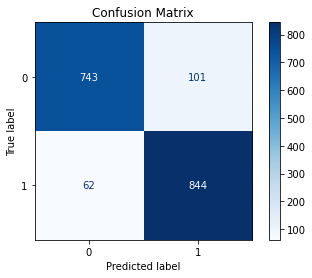

In [111]:
cm_display = ConfusionMatrixDisplay(cm).plot(cmap='Blues')
plt.title("Confusion Matrix")
s = sns.heatmap(cm_display, annot=True, annot_kws={"size": 32}, fmt="g")  # font size
s.set(xlabel="Predicted Label", ylabel="True Label")
plt.savefig('VC_Confusion_Matrix.png')

#### 10-fold cross validation with voting classifier

In [51]:
clf_labels+=['Majority voting']
all_clf += [VC]

In [52]:
for clf_, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf_, X=X_train, y=y_train, cv=10, scoring='roc_auc')
    print("ROC AUC: %0.2f +/- %0.2f [%s]" 
          % (scores.mean(), scores.std(), label))

ROC AUC: 0.94 +/- 0.01 [Support Vector Machine]
ROC AUC: 0.94 +/- 0.01 [Random Forest Classifier]
ROC AUC: 0.95 +/- 0.01 [Majority voting]


### Evaluating and tunning the ensemble classifier

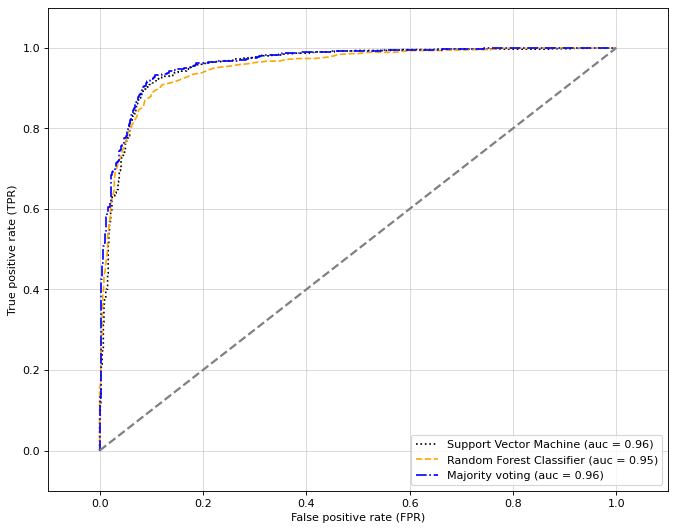

In [54]:
colors = ['black', 'orange', 'blue']
linestyles = [':','--','-.']

figure(figsize=(10, 8), dpi=80)
for clf, label, clr, ls in zip (all_clf, clf_labels, colors, linestyles):
    
#     y_pred = clf.predict(X_test).ravel().astype(int)
#     fpr, tpr, thresholds = roc_curve(np.array(y_test.values).astype(int), y_pred)
    y_pred = clf.predict_proba(X_test)[:,1]
    fpr, tpr, thresholds = roc_curve(y_true=y_test.values.astype(int), y_score=y_pred)
    
    roc_auc = auc(x=fpr, y=tpr)
    
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s (auc = %0.2f)' % (label, roc_auc))
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],
        linestyle='--',
        color='gray',
        linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.savefig('ROC_RFC_SVM_VC.png')
plt.show()
# plot_roc_curve([("model_SVM", SVM),("model_RFC",RFC),("model_VC",VC)])